<a href="https://colab.research.google.com/github/ChangED1122/Python/blob/Python-PyTorch/PyTorch_%E7%B0%A1%E5%8C%96%E7%89%88VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor #轉換成tensor格式
import  matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader #把資料分成一小堆
from torch import nn
import torch

In [ ]:
train_data = datasets.FashionMNIST(
                      root="image",
                      train=True,
                      download=True,
                      transform=ToTensor()) #轉換成tensor格式，並預先幫我們做特徵縮放

test_data = datasets.FashionMNIST(
                      root="image",
                      train=False,
                      download=True,
                      transform=ToTensor())

In [ ]:
img, label = train_data[0]
class_names = train_data.classes
label , train_data.classes

(9,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

In [ ]:
len(train_data), len(test_data) # 資料量太大做剃度下降不能全部看完再更新，速度太慢

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True) #一開始的資料是有順序的排列直接操作訓練效果不好

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataloader) , len(test_dataloader)  # 60000 / 32 , 10000 / 32

(1875, 313)

In [ ]:
x_first_batch, y_first_batch = next(iter(train_dataloader))  
x_first_batch.shape , y_first_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
x_first_batch[0].shape

torch.Size([1, 28, 28])

torch.nn Conv2d : 卷基層參數解釋 

in_channels: 灰階圖像channel=1，彩色=3

out_channels: filter有幾個

padding = 1 ,在外面補一圈0

In [ ]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1, padding=1)
conv_output = conv_layer(x_first_batch[0])  
print(conv_output.shape)
maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2, padding=0)
maxpool(conv_output).shape

torch.Size([8, 26, 26])


torch.Size([8, 13, 13])

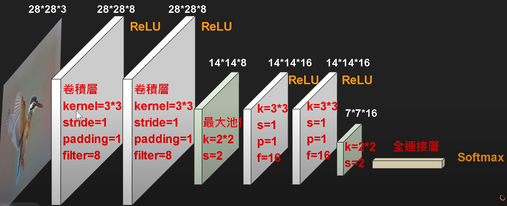

In [ ]:
class ImageClassificationModel3(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=8, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=8,
                out_channels=8, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), 
                   stride=2, 
                   padding=0
      )
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=8,
                out_channels=16, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
      ),
      nn.ReLU(),
      nn.Conv2d(in_channels=16,
                out_channels=16, 
                kernel_size=(3,3), 
                stride=1, 
                padding=1
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=(2,2), 
                   stride=2, 
                   padding=0
      )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(start_dim=1,end_dim=-1), #預設是（1,-1）這樣沒有全部攤平
        nn.Linear(in_features=16*7*7, out_features=output_shape) #如果不知道in_features要填多少，可以先跑block_1&block_2
        #nn.Softmax()  因為torch的 CrossEntropy已經包含 Softmax()
    )
    

  def forward(self,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x


In [ ]:
# model3 = ImageClassificationModel3(1, 10)
# model3(x_first_batch[0]).shape #這裡知道in_features要填 16*7*7

In [ ]:
model_3 = ImageClassificationModel3(1, 10)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_3.to(device)
cost_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.01)

In [ ]:
def accuracy_fn(y_pred, y_true):
  correct_num = ( y_pred==y_true).sum()
  acc = correct_num/len(y_true) *100
  return acc

In [ ]:
def train_step(dataloader, model, cost_fn, optimizer, accuracy_fn, device): #訓練步驟
   train_cost = 0
   train_acc = 0

   for batch, (x, y) in enumerate(dataloader):  # enumerate( ) 知道第幾個batch
    x= x.to(device)
    y= y.to(device)
    model.train()

    y_pred = model(x)

    cost = cost_fn(y_pred, y)
    train_cost += cost   #  train_cost的值=每個batch的cost加總

    train_acc += accuracy_fn(y_pred.argmax(dim=1) ,y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
  
   train_cost /= len(train_dataloader)  #取平均
   train_acc /= len(train_dataloader)
   print(f"\nTrain Cost: {train_cost:.4f}, Train Acc: {train_acc:.2f}")

def test_step(dataloader, model, cost_fn, accuracy_fn, device): #測試步驟
  test_cost = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for x, y in dataloader:
      x= x.to(device)
      y= y.to(device)
      test_pred = model(x)
      
      test_cost += cost_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1) ,y)

    test_cost /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  
  print(f"Test  Cost: {test_cost:.4f}, Test  Acc: {test_acc:.2f}  \n")

原本程式碼：
nn.Flatten(start_dim=0,end_dim=-1) 

出現錯誤 mat1 and mat2 shapes cannot be multiplied (1x25088 and 784x10)

一開始是要看model_3(x_first_batch[0]).shape  維度是16＊7＊7

更改程式碼：nn.Flatten(start_dim=1,end_dim=-1) 


因為餵進去的資料是一個batch一個batch，維度是 32＊16＊7＊7，所以要從第1個維度開始攤平 ＝32*784

In [ ]:
from tqdm.auto import tqdm  #進度條

epochs = 10
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(train_dataloader, model_3, cost_fn, optimizer, accuracy_fn, device)

  test_step(test_dataloader, model_3, cost_fn, accuracy_fn, device)

  

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
------

Train Cost: 1.0455, Train Acc: 62.58
Test  Cost: 0.5787, Test  Acc: 78.70  

Epoch: 1
------

Train Cost: 0.4972, Train Acc: 82.09
Test  Cost: 0.4679, Test  Acc: 83.70  

Epoch: 2
------

Train Cost: 0.4217, Train Acc: 84.96
Test  Cost: 0.4314, Test  Acc: 84.64  

Epoch: 3
------

Train Cost: 0.3843, Train Acc: 86.34
Test  Cost: 0.3919, Test  Acc: 86.50  

Epoch: 4
------

Train Cost: 0.3592, Train Acc: 87.16
Test  Cost: 0.3718, Test  Acc: 86.90  

Epoch: 5
------

Train Cost: 0.3394, Train Acc: 87.75
Test  Cost: 0.3569, Test  Acc: 87.44  

Epoch: 6
------

Train Cost: 0.3255, Train Acc: 88.32
Test  Cost: 0.3530, Test  Acc: 87.42  

Epoch: 7
------

Train Cost: 0.3134, Train Acc: 88.72
Test  Cost: 0.3394, Test  Acc: 87.66  

Epoch: 8
------

Train Cost: 0.3049, Train Acc: 89.13
Test  Cost: 0.3355, Test  Acc: 87.61  

Epoch: 9
------

Train Cost: 0.2953, Train Acc: 89.42
Test  Cost: 0.3263, Test  Acc: 88.12  



In [ ]:
def eval_model( dataloader, model, cost_fn, accuracy_fn, device):
  test_cost = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for x, y in dataloader:
      x= x.to(device)
      y= y.to(device)
      test_pred = model(x)
      
      test_cost += cost_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1) ,y)

    test_cost /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  return {
      "model_name": model.__class__.__name__, #取得模型名稱
      "model_cost": test_cost.item(), #.item() 單純取得裡面數字 不會有tensor格式
      "model_acc": test_acc.item()
  }

In [ ]:
model_3_result = eval_model( test_dataloader, model_3, cost_fn, accuracy_fn, device)
model_3_result #end 

{'model_name': 'ImageClassificationModel3',
 'model_cost': 0.32626792788505554,
 'model_acc': 88.11901092529297}